In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize']=10,6
import matplotlib.pyplot as plt

columns=['id',
'RI',
'Na',
'Mg', 
'Al',
'Si',
'K',
'Ca',
'Ba',
'Fe', # a derivate var which can be ignored 
'class'] 

Attribute Information:
1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
  1. building_windows_float_processed
  2. building_windows_non_float_processed
  3. vehicle_windows_float_processed
  4. vehicle_windows_non_float_processed (none in this database)
  5. containers
  6. tableware
  7. headlamps

In [3]:
df=pd.read_csv('glass.csv', names=columns)

In [4]:
df.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
df_small=df.loc[df['class']<3]

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_small.drop(['id', 'class'], axis=1), df_small['class'], stratify=df_small['class'])

Since decision trees only use ordering of feature values, there is no problem of scale difference

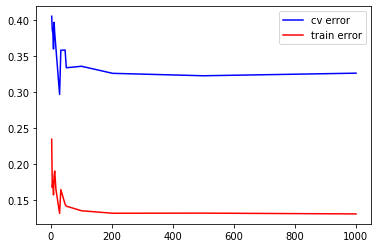

In [8]:
n_list=[3,5,7,9,11,13,17,29,33,47,51,101,203,501,1001]
cv_err=[]
train_err=[]
for n in n_list:
    clf=RandomForestClassifier(n_estimators=n, class_weight='balanced', n_jobs=-1)
    clf.fit(x_train, y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(x_train, y_train)
    
    predict_y=sig_clf.predict_proba(x_test)
    cv_err.append(log_loss(y_test, predict_y))
    
    predict_y=sig_clf.predict_proba(x_train)
    train_err.append(log_loss(y_train, predict_y))

plt.plot(n_list, cv_err, label='cv error', c='b')
plt.plot(n_list, train_err, label='train error', c='r')
plt.legend()
plt.show()

As expected, random forests, saturate after a certain n_estimator value is exceeded. They rarely overfit

In [9]:
n_list[np.argmin(cv_err)]

29

In [10]:
np.min(cv_err)

0.29691578107106237

This is significantly lower than logistic regression

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(x_test))

0.8648648648648649

In [12]:
clf=RandomForestClassifier(n_estimators=n_list[np.argmin(cv_err)], class_weight='balanced')
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=29, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [13]:
np.array([clf.feature_importances_]).T

array([[0.22930102],
       [0.07224536],
       [0.18664502],
       [0.09600744],
       [0.08622587],
       [0.05178557],
       [0.20117814],
       [0.0032329 ],
       [0.07337869]])

In [14]:
np.array([columns[1:-1]]).T

array([['RI'],
       ['Na'],
       ['Mg'],
       ['Al'],
       ['Si'],
       ['K'],
       ['Ca'],
       ['Ba'],
       ['Fe']], dtype='<U2')

In [15]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns[1:-1]]).T, np.array([clf.feature_importances_]).T)), columns=['feature', 'importance'])

In [16]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

In [17]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
0,RI,0.229301
6,Ca,0.201178
2,Mg,0.186645
3,Al,0.096007
4,Si,0.086226
8,Fe,0.073379
1,Na,0.072245
5,K,0.051786
7,Ba,0.003233


For random forest, Mg content, Al content, refractive index and Ca content are most important